In [31]:
import numpy as np
# import gftt
import matplotlib.pyplot as plt
from pygeotools.lib import warplib
import rasterio

In [3]:
def Gussian_noise_identifier(array, sigma=1, nodata_val=-9999.0):

    """
    Based on the Gaussian Low Pass filter. Default sigma = 1.
    deal with nodata values.
    https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    alse implemeted in CARST.
    """

    from scipy.ndimage import gaussian_filter
    nodata_pos = array == nodata_val
    array[nodata_pos] = 0
    w = np.ones_like(array)
    w[nodata_pos] = 0
    vv = gaussian_filter(array.astype(float), sigma)
    ww = gaussian_filter(w.astype(float), sigma)
    ww[ww == 0] = np.finfo(float).eps
    lowpass = vv / ww
    lowpass[nodata_pos] = nodata_val
    diff = np.abs(array - lowpass)
    mask = diff >= 1
    array[mask] = nodata_val
    return mask, array

In [4]:
result_x_geotiffs = ['../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne16/20180304-20180305_velo-raw_vx.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne36/20180304-20180305_velo-raw_vx.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne52/20180304-20180305_velo-raw_vx.tif']
result_y_geotiffs = ['../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vy.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne16/20180304-20180305_velo-raw_vy.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne36/20180304-20180305_velo-raw_vy.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne52/20180304-20180305_velo-raw_vy.tif']

In [6]:
result_x = []
input_x  = []
result_y = []
input_y  = []

for fn in result_x_geotiffs:
    ds_list = warplib.memwarp_multi_fn(['../synthetic_displacement/shifted_array_x.tif', fn], res='last', extent='last', t_srs='last', r='near')
    input_x.append(ds_list[0].ReadAsArray(0))
    result_x.append(ds_list[1].ReadAsArray(0))
for fn in result_y_geotiffs:
    ds_list = warplib.memwarp_multi_fn(['../synthetic_displacement/shifted_array_y.tif', fn], res='last', extent='last', t_srs='last', r='near')
    input_y.append(ds_list[0].ReadAsArray(0))
    result_y.append(ds_list[1].ReadAsArray(0))


Warping all inputs to the following:
Resolution: 120.0
Extent: [584992.5, 6718102.5, 641392.5, 6755062.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: near

1 of 2: ../synthetic_displacement/shifted_array_x.tif
nl: 308 ns: 470 res: 120.000
2 of 2: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif

Warping all inputs to the following:
Resolution: 120.0
Extent: [585052.5, 6718162.5, 641332.5, 6755002.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: near

1 of 2: ../synthetic_displacement/shifted_array_x.tif
nl: 307 ns: 469 res: 120.000
2 of 2: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne16/20180304-20180305_velo-raw_vx.tif

Warping all inputs to the following:
Resolution: 120.0
Extent: [585202.5, 6718252.5, 641242.5, 6754852.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: near

1 of 2: ../synthe

In [7]:
for i in range(len(result_x)):
    nodata_loc = result_x[i] < -9990       # NoDataValue locations
    result_x[i] /= -15                     # for unknown reason, CARST results seem to be sign-reversed
    result_y[i] /= 15
    result_x[i][nodata_loc] = -9999
    result_y[i][nodata_loc] = -9999

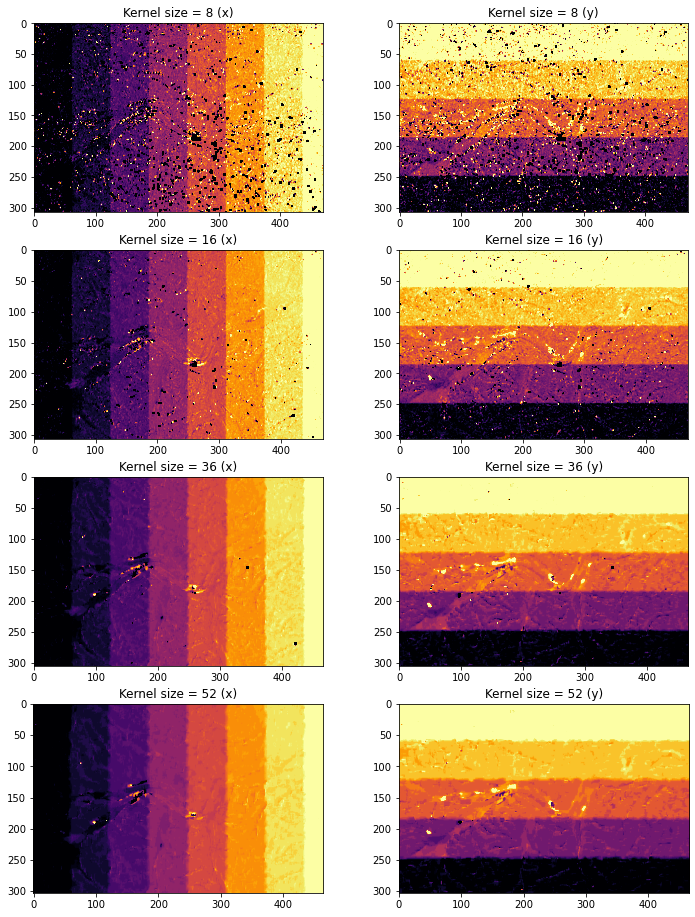

In [8]:
fig, ax1 = plt.subplots(4, 2, figsize=(12, 16))
title_string = [['Kernel size = 8 (x)', 'Kernel size = 8 (y)'], 
                ['Kernel size = 16 (x)', 'Kernel size = 16 (y)'],
                ['Kernel size = 36 (x)', 'Kernel size = 36 (y)'],
                ['Kernel size = 52 (x)', 'Kernel size = 52 (y)']]
for i in range(len(result_x)):
    ax1[i, 0].imshow(result_x[i], vmin = 0.1, vmax = 0.8, cmap='inferno')
    ax1[i, 0].set_title(title_string[i][0])
    ax1[i, 1].imshow(result_y[i], vmin = -0.5, vmax = -0.1, cmap='inferno')
    ax1[i, 1].set_title(title_string[i][1])

In [20]:
mx = []
my = []
ax = []
ay = []

for i in range(len(result_x)):
    m, a = Gussian_noise_identifier(result_x[i])
    mx.append(m)
    ax.append(a)
    m, a = Gussian_noise_identifier(result_y[i])
    my.append(m)
    ay.append(a)

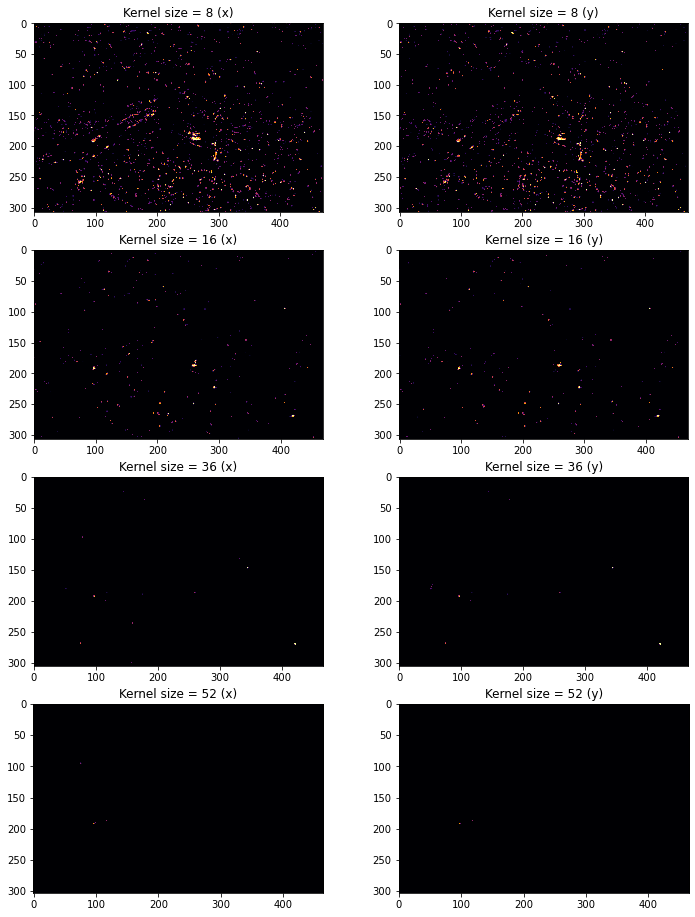

In [28]:
fig, ax2 = plt.subplots(4, 2, figsize=(12, 16))
for i in range(len(result_x)):
    ax2[i, 0].imshow(mx[i], vmin = 0.1, vmax = 0.8, cmap='inferno')
    ax2[i, 0].set_title(title_string[i][0])
    ax2[i, 1].imshow(my[i], vmin = 0.1, vmax = 0.8, cmap='inferno')
    ax2[i, 1].set_title(title_string[i][1])

In [30]:
for i in range(4):
    print(title_string[i])
    print('bad X: {} pixels'.format(np.sum(mx[i])))
    print('bad Y: {} pixels'.format(np.sum(my[i])))

['Kernel size = 8 (x)', 'Kernel size = 8 (y)']
bad X: 2739 pixels
bad Y: 2272 pixels
['Kernel size = 16 (x)', 'Kernel size = 16 (y)']
bad X: 422 pixels
bad Y: 329 pixels
['Kernel size = 36 (x)', 'Kernel size = 36 (y)']
bad X: 34 pixels
bad Y: 31 pixels
['Kernel size = 52 (x)', 'Kernel size = 52 (y)']
bad X: 7 pixels
bad Y: 4 pixels


In [32]:
result_x_geotiffs = ['../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_A_vx.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_B_vx.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_C_vx.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_D_vx.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_E_vx.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_F_vx.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_G_vx.tif']
result_y_geotiffs = ['../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_A_vy.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_B_vy.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_C_vy.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_D_vy.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_E_vy.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_F_vy.tif',
                     '../../data/CARST/20180818-20180903/20180818-20180903_velo-raw_G_vy.tif']

In [34]:
result_x2 = []
result_y2 = []

for fn in result_x_geotiffs:
    ds = rasterio.open(fn)
    result_x2.append(ds.read(1))
for fn in result_y_geotiffs:
    ds = rasterio.open(fn)
    result_y2.append(ds.read(1))

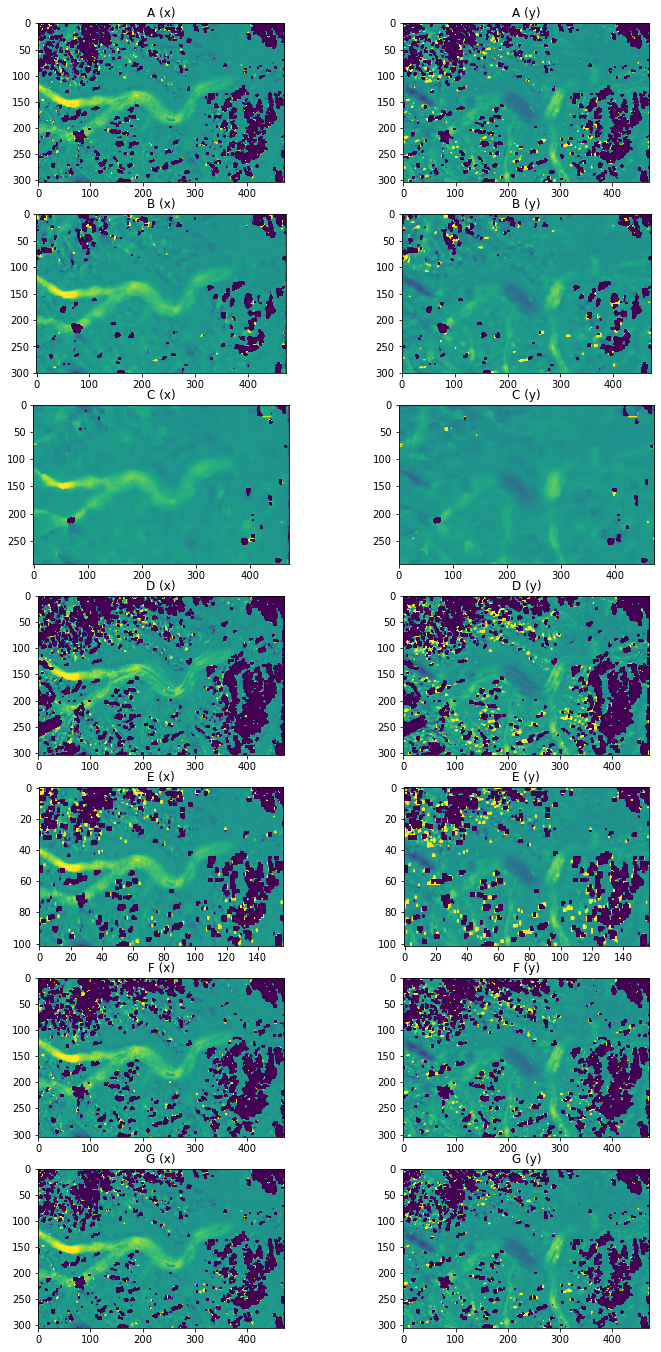

In [43]:
fig, ax1 = plt.subplots(7, 2, figsize=(12, 24))
title_string2 = [['A (x)', 'A (y)'], 
                ['B (x)', 'B (y)'],
                ['C (x)', 'C (y)'],
                ['D (x)', 'D (y)'],
                ['E (x)', 'E (y)'],
                ['F (x)', 'F (y)'],
                ['G (x)', 'G (y)'],]
for i in range(len(result_x2)):
    ax1[i, 0].imshow(result_x2[i], vmin = -1, vmax = 1)
    ax1[i, 0].set_title(title_string2[i][0])
    ax1[i, 1].imshow(result_y2[i], vmin = -1, vmax = 1)
    ax1[i, 1].set_title(title_string2[i][1])

In [44]:
mx = []
my = []
ax = []
ay = []

for i in range(len(result_x2)):
    m, a = Gussian_noise_identifier(result_x2[i])
    mx.append(m)
    ax.append(a)
    m, a = Gussian_noise_identifier(result_y2[i])
    my.append(m)
    ay.append(a)

In [45]:
for i in range(7):
    print(title_string2[i])
    print('bad X: {} pixels'.format(np.sum(mx[i])))
    print('bad Y: {} pixels'.format(np.sum(my[i])))

['A (x)', 'A (y)']
bad X: 16818 pixels
bad Y: 17090 pixels
['B (x)', 'B (y)']
bad X: 6344 pixels
bad Y: 6418 pixels
['C (x)', 'C (y)']
bad X: 755 pixels
bad Y: 784 pixels
['D (x)', 'D (y)']
bad X: 25086 pixels
bad Y: 25145 pixels
['E (x)', 'E (y)']
bad X: 2415 pixels
bad Y: 2488 pixels
['F (x)', 'F (y)']
bad X: 21601 pixels
bad Y: 21671 pixels
['G (x)', 'G (y)']
bad X: 16570 pixels
bad Y: 16536 pixels


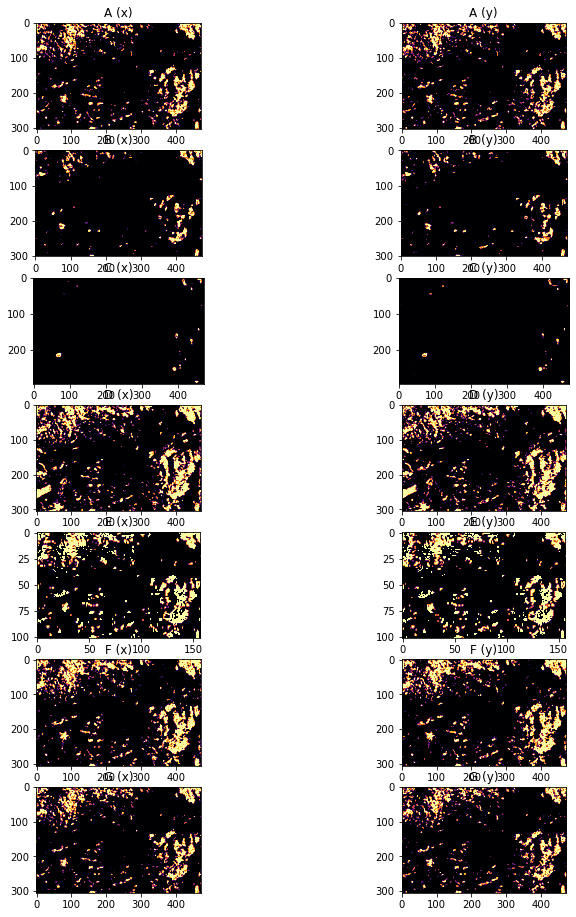

In [46]:
fig, ax2 = plt.subplots(7, 2, figsize=(12, 16))
for i in range(len(result_x2)):
    ax2[i, 0].imshow(mx[i], vmin = 0.1, vmax = 0.8, cmap='inferno')
    ax2[i, 0].set_title(title_string2[i][0])
    ax2[i, 1].imshow(my[i], vmin = 0.1, vmax = 0.8, cmap='inferno')
    ax2[i, 1].set_title(title_string2[i][1])

In [48]:
!cat ../../data/CARST/20180818-20180903/Readme.txt

[A]
refwindow = 32
searchwindow = 9
skip = 8
gaussian_hp = 1

[B]
refwindow = 64
searchwindow = 9
skip = 8
gaussian_hp = 1

[C]
refwindow = 128
searchwindow = 9
skip = 8
gaussian_hp = 1

[D]
refwindow = 32
searchwindow = 9
skip = 8
gaussian_hp = 0

[E]
refwindow = 32
searchwindow = 9
skip = 24
gaussian_hp = 1

[F]
refwindow = 32
searchwindow = 9
skip = 8
gaussian_hp = 1 (sigma = 9)

[G]
refwindow = 32
searchwindow = 9
skip = 8
gaussian_hp = 2 (GHP-3sig_Canny2dila-masked)